In [36]:
from nsaba.nsaba import Nsaba
from nsaba.nsaba.visualizer import NsabaVisualizer
from nsaba.nsaba.geneinfo import gene_info
import pandas as pd
from scipy import stats
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
plt.style.use('ggplot')
%matplotlib inline

In [37]:
# Loading NS & ABA datafiles

data_dir = '../../data_dir'
Nsaba.aba_load(data_dir)
Nsaba.ns_load(data_dir)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [28]:
# Intializing Nsaba object and loading gene expression

tnsaba = Nsaba()
tnsaba.load_ge_pickle('../../data_dir/Nsaba_ABA_ge.pkl')

This may take a minute or two ...
'ge' dictionary successfully loaded


In [79]:
tnsaba.is_term('olfactory')

True

In [110]:
# Setting term and Entrez IDs

term = 'olfactory'
gene = [9288]

In [111]:
# Generating estimated tf-idf coefficients

tnsaba.get_ns_act(term, thresh=-1)

This may take a few minutes...


In [112]:
# Visualizing coefficient distribution

V = NsabaVisualizer(tnsaba)
V.visualize_ge(gene)
V.visualize_ns(term)

Gene 9288 has not been initialized. Use self.no.get_aba_ge([9288])


UnboundLocalError: local variable 'ax' referenced before assignment

In [ ]:
# Descriptive statistics of term and gene coefficients

analmat = tnsaba.make_ge_ns_mat(term, gene)
tsaba_df = pd.DataFrame(analmat)
tsaba_df.describe()

In [ ]:
# Hypothesis testing pre-processing
thres = 0

gt_thres = [row[0] for row in analmat if row[1] > thres]
lt_thres = [row[0] for row in analmat if row[1] <= thres]
len(gt_thres)

In [93]:
# Clustering to determine control and functional coordinate groups

X = [[x] for x in analmat[:,1]]
kmn = KMeans(n_clusters=2)
kmn.fit(X)
group1 = [row[0] for row in analmat if kmn.predict(row[1]) == 0]
group2 = [row[0] for row in analmat if kmn.predict(row[1]) == 1]
print min([len(group1), len(group2)])

3


In [94]:
gm = mixture.GMM(n_components=2)
gm.fit(X)

group1 = [row[0] for row in analmat if gm.predict([row[1]]) == 0]
group2 = [row[0] for row in analmat if gm.predict([row[1]]) == 1]
print min([len(group1), len(group2)])

3


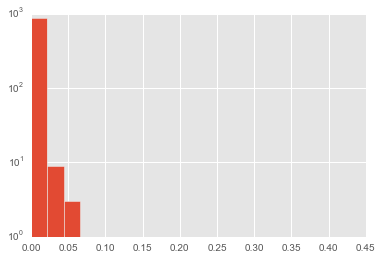

In [105]:

plt.hist(analmat[:,1], bins=20, log=True);

In [96]:
# Effect Size

def cohen_d(x1, x2, n1, n2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt( ((n1-1)*np.var(x1) + (n2-1)*np.var(x2)) / (n1 + n2 -2) )

In [106]:
# T-Test
print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
print "Effect size: %.4f \n" % cohen_d(lt_thres,gt_thres,len(lt_thres),len(gt_thres))
# U-Test
print "Rank: %d \np-value: %.3E " % stats.mannwhitneyu(lt_thres, gt_thres)

t-value: -0.5197 
p-value: 6.034E-01
Effect size: -0.0813 

Rank: 17251 
p-value: 3.328E-01 


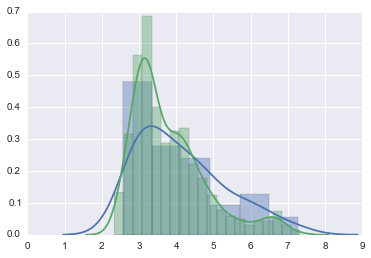

In [39]:
# Distributions of LT & GT thresholds

sns.distplot(gt_thres);
sns.distplot(lt_thres);

In [48]:
# Combining it all ...

def gene_term_ttest(gene, term, quant):
    analmat = tnsaba.make_ge_ns_mat(term, [gene])
    tsaba_df = pd.DataFrame(analmat)
    thres = tsaba_df.quantile(quant)[1]
    gt_thres = [row[0] for row in analmat if row[1] > thres]
    lt_thres = [row[0] for row in analmat if row[1] <= thres]
    # T-Test
    print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
    print "Effect size: %.4f \n" % cohen_d(lt_thres,gt_thres,len(lt_thres),len(gt_thres))
    sns.distplot(gt_thres);
    sns.distplot(lt_thres);

t-value: -5.3812 
p-value: 9.504E-08
Effect size: -0.5089 



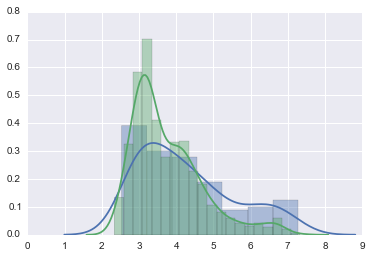

In [57]:
gene_term_ttest(1813, 'reward', .85)

In [64]:
# Setting term
term_ = 'reward'
tnsaba.get_ns_act(term_, thresh=-1)

This may take a few minutes...


In [10]:
# Finding smallest p-values across all Entrez IDs

## Parameters:
term = 'reward'
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
thres = pd.DataFrame(tnsaba.term[term]['ns_act_vector']).quantile(.85)[0]
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")
    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]
aba_sam_num = len(ge_mat[0])

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] > thres]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] <= thres]
    test_stats = stats.ttest_ind(lt_thres, gt_thres)
    d = cohen_d(lt_thres, gt_thres, len(lt_thres), len(gt_thres))
    if test_stats[0] <= 0:
        gene_p.append( (eid, d, test_stats[1]) )
    else:
        continue

# Sorting from greatest magnitude of effect size
gene_p.sort(key=lambda ge: ge[1])

In [8]:
# Using K-Means instead of variance cuts.

## Parameters:
term = 'reward'
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")
    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]
aba_sam_num = len(ge_mat[0])
kmn = KMeans(n_clusters=2)
X = [[x] for x in tnsaba.term[term]['ns_act_vector']]
Y = kmn.fit_predict(X)

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if Y[i] == 1]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if Y[i] == 0]
    test_stats = stats.ttest_ind(lt_thres, gt_thres)
    d = cohen_d(lt_thres, gt_thres, len(lt_thres), len(gt_thres))
    if test_stats[0] <= 0:
        gene_p.append( (eid, d, test_stats[1]) )
    else:
        continue

# Sorting from greatest magnitude of effect size
gene_p.sort(key=lambda ge: ge[1])

In [10]:
top_genes = []
for i in xrange(top_id_return):
    try:
        top_genes.append( (gene_p[i][0], gene_p[i][1], gene_p[i][2], gene_info(str(gene_p[i][0]))[0]) )
    except TypeError:
        continue
## Some ABA genes are not registered with NIH

In [11]:
alpha = .05
print "Corrected Bonferoni Alpha: %.3E\n\n" % (alpha/float(sample_num))
for eid, coh_d, p_val, descr in top_genes:
    if len(descr) == 1:
        print "%d (p = %.3E; d = %.3f): < No description found >\n\n" % (eid, p_val, coh_d)    
    else:
        print "%d (p = %.3E; d = %.3f): %s\n\n" % (eid, p_val, coh_d, descr)

Corrected Bonferoni Alpha: 2.405E-06


7349 (p = 1.044E-06; d = -0.619): urocortin


374462 (p = 1.937E-05; d = -0.540): protein tyrosine phosphatase, receptor type, Q


401433 (p = 1.142E-04; d = -0.487): uncharacterized LOC401433


282890 (p = 1.240E-04; d = -0.484): zinc finger protein 311


167681 (p = 1.273E-04; d = -0.483): protease, serine, 35


56886 (p = 2.039E-04; d = -0.469): UDP-glucose glycoprotein glucosyltransferase 1


5456 (p = 2.207E-04; d = -0.466): POU class 3 homeobox 4


93556 (p = 2.860E-04; d = -0.457): EGF-like and EMI domain containing 1, pseudogene


3169 (p = 2.902E-04; d = -0.457): forkhead box A1


5277 (p = 3.055E-04; d = -0.455): phosphatidylinositol glycan anchor biosynthesis, class A


140828 (p = 3.936E-04; d = -0.447): long intergenic non-protein coding RNA 261


4319 (p = 4.151E-04; d = -0.446): matrix metallopeptidase 10


114882 (p = 4.474E-04; d = -0.443): oxysterol binding protein-like 8


441052 (p = 5.929E-04; d = -0.433): uncharacterized LOC4

Percent Significant (Bonferroni Correction; alpha = .05): 0.005 %


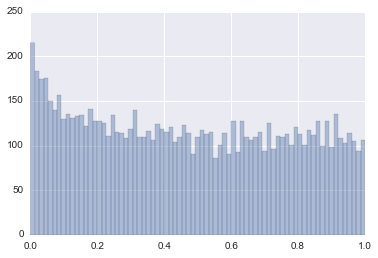

In [12]:
# Visualizing p-value distribution
p_vals = [p[2] for p in gene_p ]
sig = sum([ p < .05/sample_num for p in p_vals])
print "Percent Significant (Bonferroni Correction; alpha = .05): %.3f %%" % (100*sig/float(sample_num))
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);

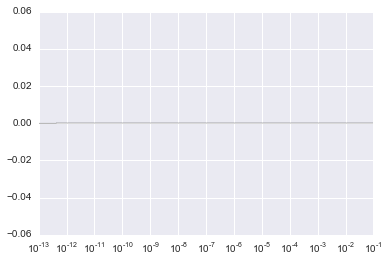

In [23]:
# Log-scale Visualization of p-values
plt.hist(p_vals, bins=np.logspace(-13, -1, 20));
plt.xscale('log')

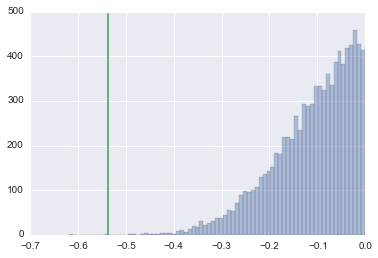

In [14]:
# Visualizing effect-size distribution
p_vals = [p[1] for p in gene_p ]
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);
sns.rugplot([-0.5386], height=495);
# Green line DRD2 effect size

In [15]:
p_less_than_d2 = sum([ p < 1.297E-08 for p in p_vals])
print " p-values less than DRD2 gene p-value: %.3f %%" % (100*p_less_than_d2/float(sample_num))

 p-values less than DRD2 gene p-value: 43.147 %


Writing test.txt
